In [ ]:
# !pip install skforecast

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import pacf
import numpy as np
from xgboost import XGBRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skforecast.model_selection import backtesting_forecaster

c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_lag_features(data):
    y = data['load']
    scaler = StandardScaler()
    features = pd.DataFrame()
    
    partial = pd.Series(data=pacf(y, nlags=168))

    #takes lags with pacf >= 0.2
    lags = list(partial[np.abs(partial) >= 0.2].index)
    
    return lags[1:]

In [3]:
def calculate_mae(actual, predicted):
    return np.mean(np.abs(actual - predicted))

def calculate_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

In [4]:
#Reading the data 
#===========================================================================================================================================
pd.set_option('display.float_format', lambda x: '%.5f' % x)
data = pd.read_csv('xgb_data.csv')
data['time'] = pd.to_datetime(data['time'], dayfirst = True)
data = data.rename(columns={'load_kw':'load'})

In [5]:
data.head()

,time,load,pressure_f,cloud_cov_f,temp_f,wind_dir_f,wind_sp_f,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,covid,pub_hol
0,2017-03-18 00:00:00,1031471.62800,1011.00000,3.00000,14.00000,307.00000,2.00000,0.00000,1.00000,1.00000,0.00000,-0.48530,-0.87435,0,0
1,2017-03-18 01:00:00,1007205.57800,1011.00000,4.00000,14.00000,215.00000,2.00000,0.25882,0.96593,1.00000,0.00000,-0.48530,-0.87435,0,0
2,2017-03-18 02:00:00,986108.40070,1011.00000,4.00000,14.00000,123.00000,1.00000,0.50000,0.86603,1.00000,0.00000,-0.48530,-0.87435,0,0
3,2017-03-18 03:00:00,970760.96690,1011.00000,4.00000,14.00000,31.00000,1.00000,0.70711,0.70711,1.00000,0.00000,-0.48530,-0.87435,0,0
4,2017-03-18 04:00:00,962258.36500,1011.00000,4.00000,14.00000,138.00000,1.00000,0.86603,0.50000,1.00000,0.00000,-0.48530,-0.87435,0,0


### Multi-step Forecasting

In [5]:
# Data preprocessing
# ==============================================================================
data = data.set_index('time')
data = data.asfreq('H')
data_train = data[:int((len(data)+1)*.9)]
data_test = data[int(len(data)*.9):]

#dependent variables
x_vars = list(data.columns)[1:]
lags = create_lag_features(data)


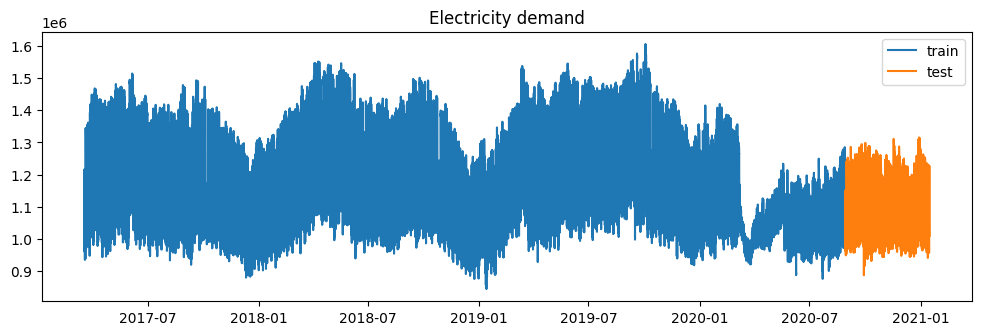

In [6]:
fig, ax = plt.subplots(figsize=(12, 3.5))

ax.plot(data_train.index, data_train.load, label='train')
ax.plot(data_test.index, data_test.load, label='test')

ax.set_title('Electricity demand')
ax.legend();

#### XGBoost without parameter tuning & without scaling

In [7]:
# Create and fit forecaster WITHOUT parameter tuning!!!
# ==============================================================================
forecaster = ForecasterAutoreg(
                     regressor = XGBRegressor(
                            seed=3164,
                            learning_rate =0.1,
                            n_estimators=1000,
                            max_depth=5,
                            min_child_weight=1,
                            gamma=0,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            scale_pos_weight=1,
                     ),
                    lags = 168
             )

forecaster.fit(y=data_train['load'], exog=data_train[x_vars])

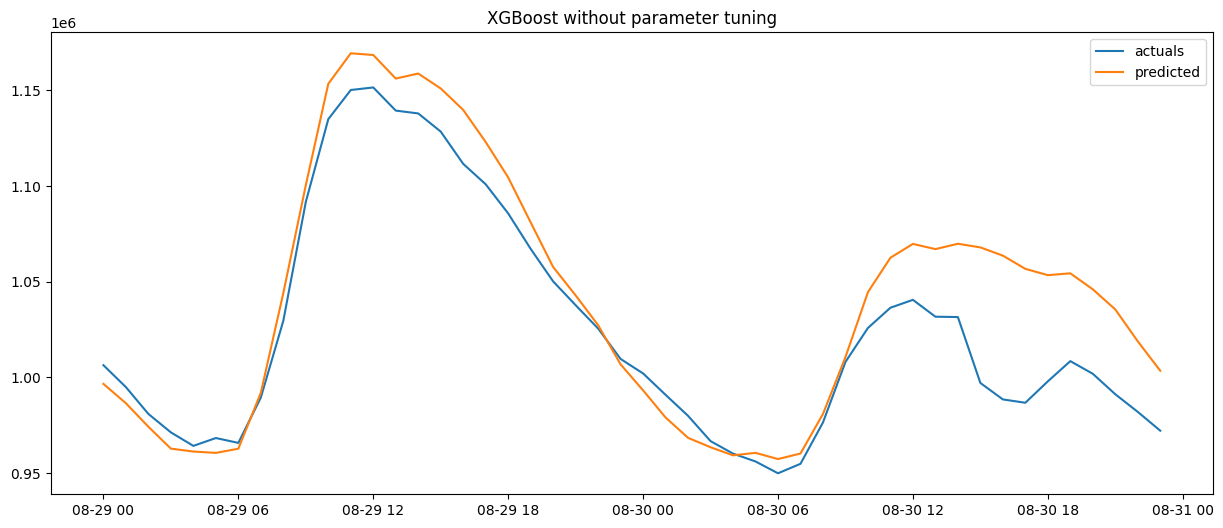

In [8]:
# Predict 48 hours 
# ==============================================================================
predicted = forecaster.predict(steps=48, exog=data_test[x_vars][:48])
testing_set = data_test['load'][:48].to_frame()
testing_set['predicted'] = predicted
plt.figure(figsize=(15,6))
plt.plot(testing_set['load'])
plt.plot(testing_set['predicted'])
plt.legend(['actuals','predicted'])
plt.title('XGBoost without parameter tuning')
plt.show()

In [9]:
mae = calculate_mae(testing_set['load'], testing_set['predicted'])
mape = calculate_mape(testing_set['load'], testing_set['predicted'])
rmse = calculate_rmse(testing_set['load'], testing_set['predicted'])

print('MAE: '+ str(mae))
print('MAPE: '+ str(mape))
print('RMSE: '+ str(rmse))

MAE: 20194.843756249993
MAPE: 1.973798799783059
RMSE: 27703.199638155944


In [17]:
imp = forecaster.get_feature_importances()
imp = imp.set_index('feature')

In [19]:
imp.loc[['hour_cos', 'hour_sin', 
        'day_cos', 'day_sin', 
        'month_cos', 'month_sin']]

,importance
feature,
lag_1,0.18486
lag_2,0.02211
lag_3,0.02672
lag_4,0.00054
lag_5,0.00032
...,...
month_cos,0.00029
day_sin,0.00011
day_cos,0.00007


#### XGBoost without parameter tuning & WITH scaling

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
scaler = StandardScaler()
scaled_data_train = pd.DataFrame(scaler.fit_transform(data_train),
                                columns = data_train.columns,
                                index = data_train.index)

scaled_data_test = pd.DataFrame(scaler.fit_transform(data_test),
                                columns = data_test.columns,
                                index = data_test.index)                                

In [22]:
scaled_data_train.head()

,load,pressure_f,cloud_cov_f,temp_f,wind_dir_f,wind_sp_f,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,covid,pub_hol
time,,,,,,,,,,,,,,
2017-03-18 00:00:00,-0.81986,0.47591,-0.83848,-0.51289,0.96572,-1.57681,-0.00000,1.41421,1.41471,0.12879,-0.67132,-1.22418,-0.39894,-0.19684
2017-03-18 01:00:00,-0.97942,0.47591,-0.80609,-0.51289,-0.02312,-1.57681,0.36603,1.36603,1.41471,0.12879,-0.67132,-1.22418,-0.39894,-0.19684
2017-03-18 02:00:00,-1.11815,0.47591,-0.80609,-0.51289,-1.01197,-1.70687,0.70711,1.22474,1.41471,0.12879,-0.67132,-1.22418,-0.39894,-0.19684
2017-03-18 03:00:00,-1.21907,0.47591,-0.80609,-0.51289,-2.00082,-1.70687,1.00000,1.00000,1.41471,0.12879,-0.67132,-1.22418,-0.39894,-0.19684
2017-03-18 04:00:00,-1.27498,0.47591,-0.80609,-0.51289,-0.85074,-1.70687,1.22474,0.70711,1.41471,0.12879,-0.67132,-1.22418,-0.39894,-0.19684


In [ ]:
scaled_data_test.head()

In [33]:
forecaster_scaled = ForecasterAutoreg(
                    regressor = XGBRegressor(
                            seed=3164,
                            learning_rate =0.1,
                            n_estimators=1000,
                            max_depth=5,
                            min_child_weight=1,
                            gamma=0,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            scale_pos_weight=1,),
                    lags = 168
             )

forecaster_scaled.fit(y=scaled_data_train['load'], 
              exog=scaled_data_train[x_vars])
forecaster_scaled

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57 

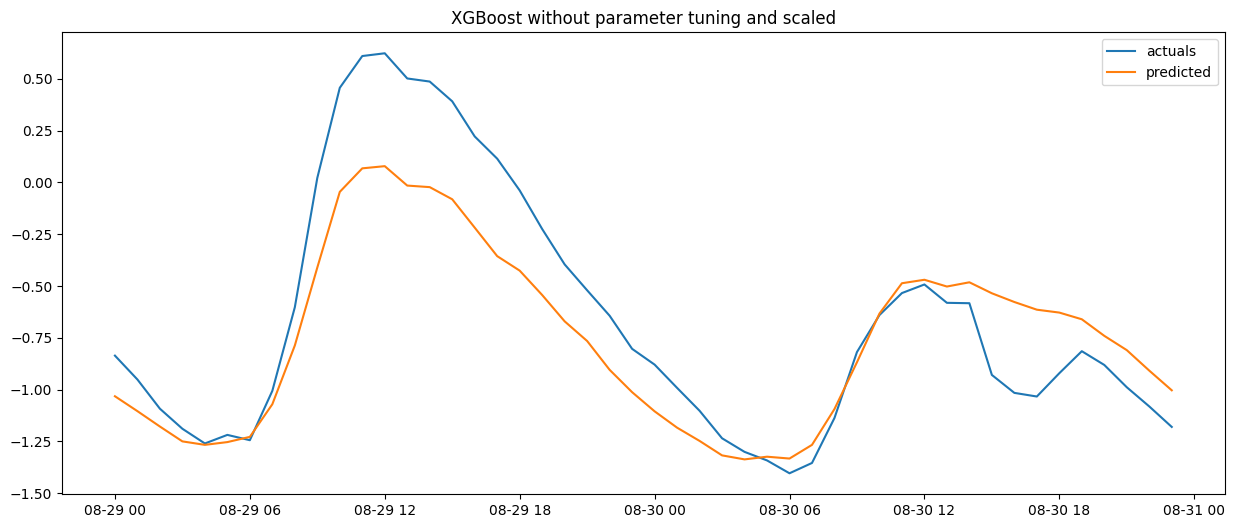

In [34]:
# Predict 48 hours 
# ==============================================================================
predicted = forecaster_scaled.predict(steps=48, exog=scaled_data_test[x_vars][:48])
testing_set = scaled_data_test['load'][:48].to_frame()
testing_set['predicted'] = predicted
plt.figure(figsize=(15,6))
plt.plot(testing_set['load'])
plt.plot(testing_set['predicted'])
plt.legend(['actuals','predicted'])
plt.title('XGBoost without parameter tuning and scaled')
plt.show()

In [35]:
mae = calculate_mae(testing_set['load'], testing_set['predicted'])
mape = calculate_mape(testing_set['load'], testing_set['predicted'])
rmse = calculate_rmse(testing_set['load'], testing_set['predicted'])
print('MAE: '+ str(mae))
print('MAPE: '+ str(mape))
print('RMSE: '+ str(rmse))

MAE: 0.21886707202788372
MAPE: 104.09953377737338
RMSE: 0.27788867105611587


WHAT ARE THESE STATS HAHJHFDSJH

In [27]:
from skforecast.model_selection import grid_search_forecaster

c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# Default values first okok -- initial estimates of params
# ==============================================================================
sl_forecaster = ForecasterAutoreg(
                     regressor = XGBRegressor(
                            seed=3164,
                            learning_rate = 0.1,
                            n_estimators=1000,
                            max_depth=5,
                            min_child_weight=1,
                            gamma=0,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            scale_pos_weight=1,
                     ),
                    lags = lags
             )

sl_forecaster.fit(y=data_train['load'], exog=data_train[x_vars])

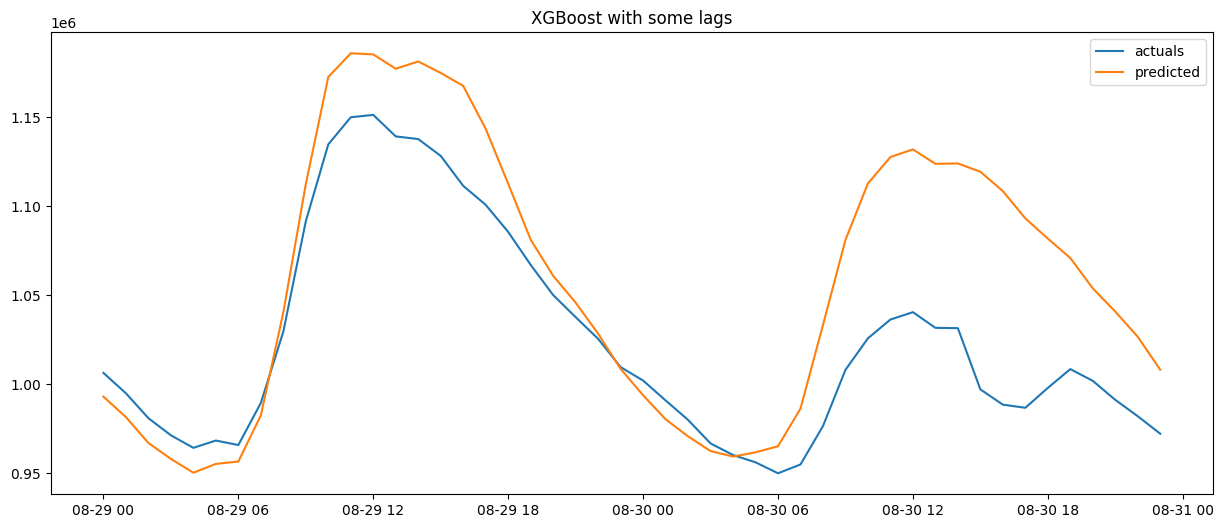

In [20]:
# Predict 48 hours 
# ==============================================================================
predicted = sl_forecaster.predict(steps=48, exog=data_test[x_vars][:48])
testing_set = data_test['load'][:48].to_frame()
testing_set['predicted'] = predicted
plt.figure(figsize=(15,6))
plt.plot(testing_set['load'])
plt.plot(testing_set['predicted'])
plt.legend(['actuals','predicted'])
plt.title('XGBoost with some lags')
plt.show()

In [21]:
mae = calculate_mae(testing_set['load'], testing_set['predicted'])
mape = calculate_mape(testing_set['load'], testing_set['predicted'])
rmse = calculate_rmse(testing_set['load'], testing_set['predicted'])
print('MAE: '+ str(mae))
print('MAPE: '+ str(mape))
print('RMSE: '+ str(rmse))

MAE: 39083.703833333326
MAPE: 3.8076686936547985
RMSE: 51825.32903058305


In [22]:
metrics = ['mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_error']

In [23]:
# Backtesting on training data EXTENDING WINDOW (some lags) 
# ==============================================================================
ext_metric, predictions = backtesting_forecaster(
                          forecaster            = sl_forecaster,
                          y                     = data_train['load'],
                          exog                  = data_train[x_vars],
                          steps                 = 2160,  #extends by 3 months
                          metric                = metrics,
                          initial_train_size    = 4320,  #6 months
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = True,
                          verbose               = True,
                          show_progress         = False
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 4320
Number of observations used for backtesting: 25920
    Number of folds: 12
    Number of steps per fold: 2160
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2017-03-18 00:00:00 -- 2017-09-13 23:00:00  (n=4320)
    Validation: 2017-09-14 00:00:00 -- 2017-12-12 23:00:00  (n=2160)
Fold: 1
    Training:   2017-03-18 00:00:00 -- 2017-12-12 23:00:00  (n=6480)
    Validation: 2017-12-13 00:00:00 -- 2018-03-12 23:00:00  (n=2160)
Fold: 2
    Training:   2017-03-18 00:00:00 -- 2018-03-12 23:00:00  (n=8640)
    Validation: 2018-03-13 00:00:00 -- 2018-06-10 23:00:00  (n=2160)
Fold: 3
    Training:   2017-03-18 00:00:00 -- 2018-06-10 23:00:00  (n=10800)
    Validation: 2018-06-11 00:00:00 -- 2018-09-08 23:00:00  (n=2160)
Fold: 4
    Training:   2017-03-18 00:00:00 -- 2018-09-08 23:00:00  (n=12960)
    Validation: 20

Text(0.5, 1.0, 'Extending window (SOME LAGS)')

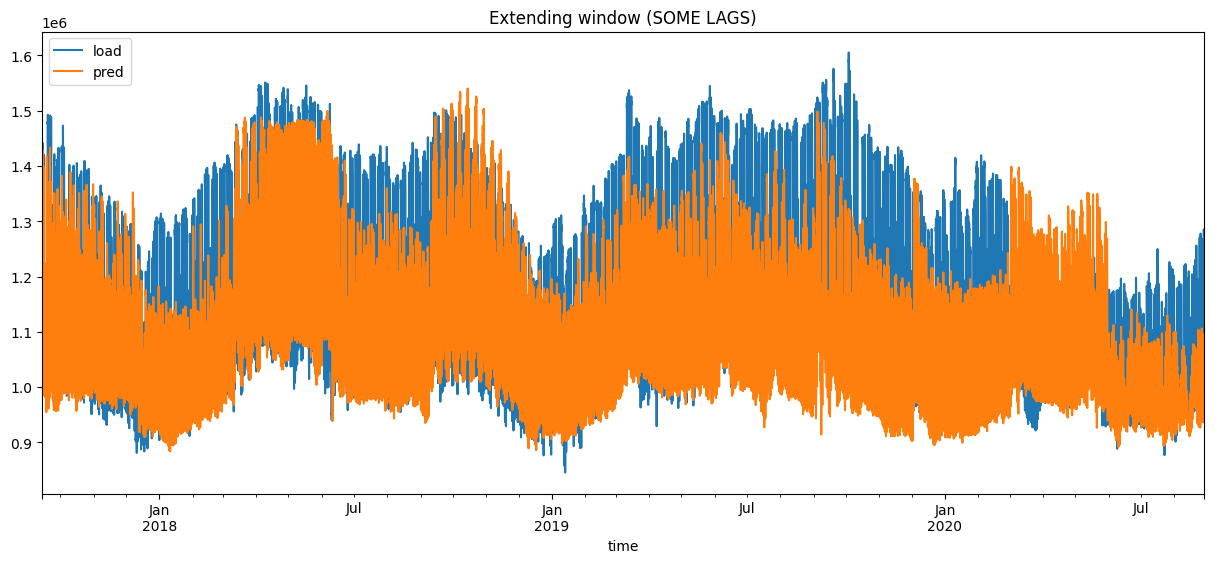

In [24]:
#extending window
fig, ax = plt.subplots(figsize=(15, 6))
data_train['load'].iloc[4320:].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend(loc="upper left")
plt.title('Extending window (SOME LAGS)')

In [25]:
print('MAE for extending window: ' + str(ext_metric[0]))
print('MAPE for extending window: ' + str(ext_metric[1]))
print('RMSE for extending window: ' + str(math.sqrt(ext_metric[2])))

MAE for extending window: 84833.83174785496
MAPE for extending window: 0.07128433353035504
RMSE for extending window: 111752.53072424377


rmse is so high? but why 

In [26]:
# Backtesting on training data SLIDING WINDOW
# ==============================================================================
slide_metric, sliding_predictions = backtesting_forecaster(
                          forecaster            = sl_forecaster,
                          y                     = data_train['load'],
                          exog                  = data_train[x_vars],
                          steps                 = 48,     #slides by 2 days, retrains by 3 months
                          metric                = metrics,
                          initial_train_size    = 2160,  #6 months
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = True,
                          verbose               = True,
                          show_progress         = True
                      )

c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\model_selection\model_selection.py:527: LongTrainingWarning: The forecaster will be fit 585 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(


Information of backtesting process
----------------------------------
Number of observations used for initial training: 2160
Number of observations used for backtesting: 28080
    Number of folds: 585
    Number of steps per fold: 48
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2017-03-18 00:00:00 -- 2017-06-15 23:00:00  (n=2160)
    Validation: 2017-06-16 00:00:00 -- 2017-06-17 23:00:00  (n=48)
Fold: 1
    Training:   2017-03-20 00:00:00 -- 2017-06-17 23:00:00  (n=2160)
    Validation: 2017-06-18 00:00:00 -- 2017-06-19 23:00:00  (n=48)
Fold: 2
    Training:   2017-03-22 00:00:00 -- 2017-06-19 23:00:00  (n=2160)
    Validation: 2017-06-20 00:00:00 -- 2017-06-21 23:00:00  (n=48)
Fold: 3
    Training:   2017-03-24 00:00:00 -- 2017-06-21 23:00:00  (n=2160)
    Validation: 2017-06-22 00:00:00 -- 2017-06-23 23:00:00  (n=48)
Fold: 4
    Training:   2017-03-26 00:00:00 -- 2017-06-23 23:00:00  (n=2160)
    Validation: 2017-06-24 00

100%|██████████| 585/585 [06:42<00:00,  1.45it/s]


Text(0.5, 1.0, 'sliding window (SOME LAGS)')

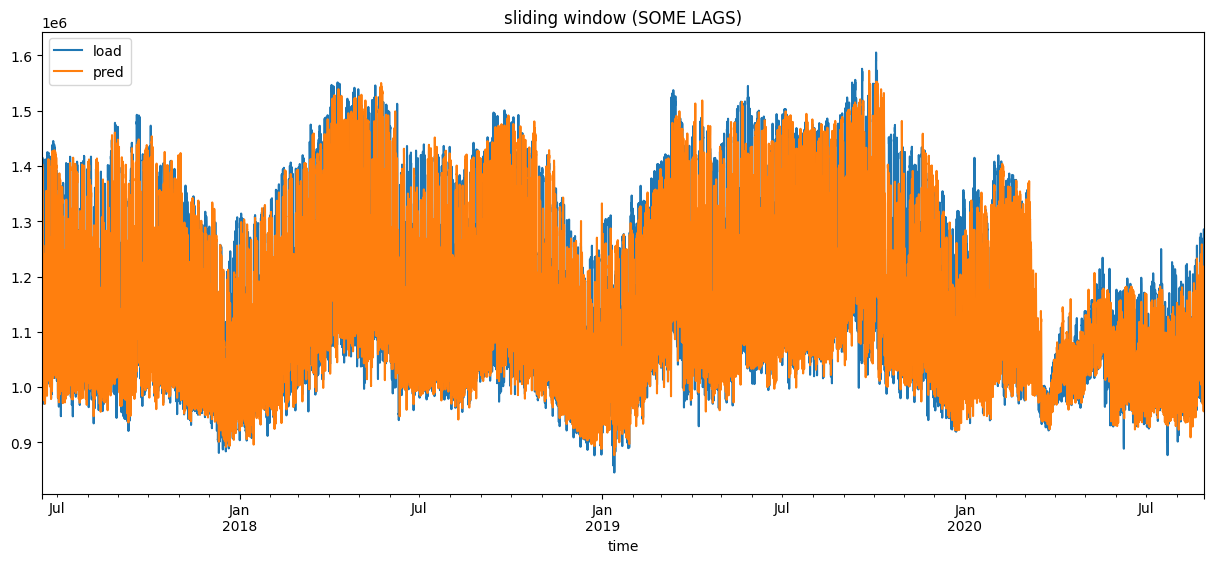

In [27]:
# sliding window
fig, ax = plt.subplots(figsize=(15, 6))
data_train['load'].iloc[2160:].plot(ax=ax)
sliding_predictions.plot(ax=ax)
ax.legend(loc="upper left");
plt.title('sliding window (SOME LAGS)')

In [28]:
print('MAE for sliding window: ' + str(slide_metric[0]))
print('MAPE for sliding window: ' + str(slide_metric[1]))
print('RMSE for sliding window: ' + str(math.sqrt(slide_metric[2])))

MAE for sliding window: 37180.16553804843
MAPE for sliding window: 0.03157017614067616
RMSE for sliding window: 59213.39426932311


rmse is so high? but why

### TUNING

In [ ]:
#DON'T RUN THIS IT'S JUST TO DOCUMENT WHAT PARAMS I USED FOR INITIAL TUNING
#AND THE FINAL PARAMS
tuning_params: 
    {'n_estimators': [100,500,1000] --> 500,
    'learning_rate': [0.03, 0.05, 0.1] --> 0.05,
    'max_depth': range(3,10,2) --> 7,
    'min_child_weight': range(1,6,2) --> 3,
    'gamma': [i/10 for i in range (0,5)],
    }

In [103]:
# Hyperparameter grid search 
# ==============================================================================
steps = 48
# forecaster = ForecasterAutoreg(
#                 regressor = XGBRegressor(),
#                 lags      = 168 # This value will be replaced in the grid search
#              )

# Lags used as predictors
lags_grid = [1, 168]

# Regressor's hyperparameters
param_grid = { 'max_depth': [7],
           'learning_rate': [0.05],
           'n_estimators': [500],
           'gamma': [0],
           'min_child_weight': [3],
        #    'subsample':[i/100.0 for i in range(65,80,5)],
        #    'colsample_bytree':[i/100 for i in range(55,70,5)]
           'colsample_bytree': [0.55],
           'subsample': [0.75]
           }

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['load'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = metrics,
                        initial_train_size = int(len(data_train)*0.5),                        
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = True
               )

Number of models compared: 18.


lags grid: 100%|██████████| 2/2 [07:43<00:00, 231.82s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
  Parameters: {'colsample_bytree': 0.55, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.75}
  Backtesting metric: 30523.171782685185



In [142]:
#Training with the best found parameters above 
#========================================================================
tuned_params ={ 'max_depth': [7],
           'learning_rate': [0.05],
           'n_estimators': [500],
           'gamma': [0],
           'min_child_weight': [3]}

forecaster_tuned = ForecasterAutoreg(
                    regressor = XGBRegressor(
                        max_depth=7,
                        learning_rate=0.03,
                        n_estimators=500,
                        gamma=0,
                        min_child_weight=3,
                        subsample=0.75,
                        colsample_bytree=0.55
                        ),
                    lags = lags
                )

forecaster_tuned.fit(y=data_train['load'], exog=data_train[x_vars])

In [143]:
steps = len(data_test)
predicted = forecaster_tuned.predict(steps=steps, exog=data_test[x_vars][:steps])
testing_set = data_test['load'][:steps].to_frame()
testing_set['predicted'] = predicted

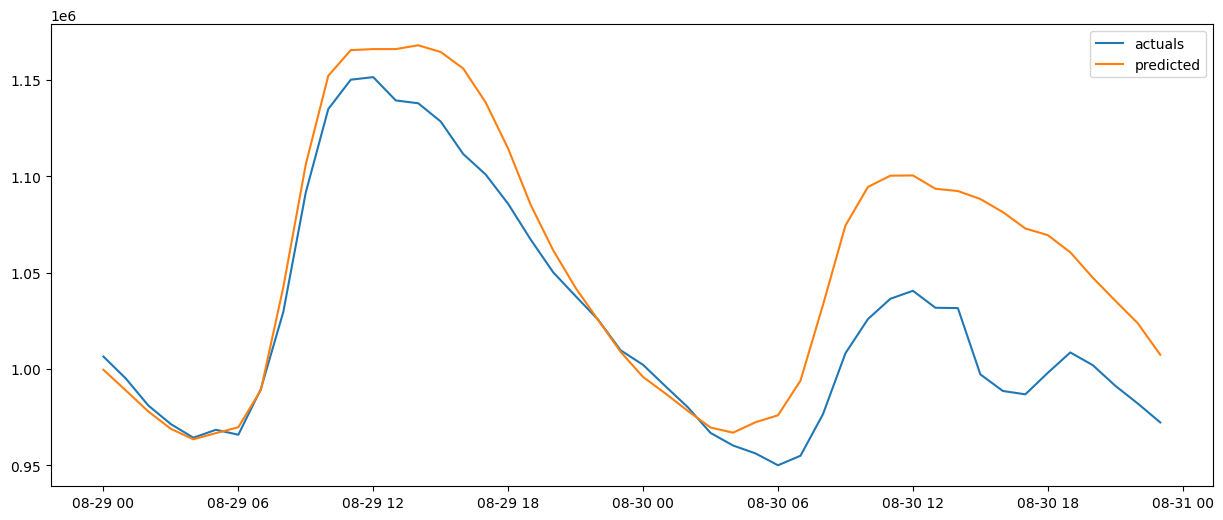

In [144]:
plt.figure(figsize=(15,6))
plt.plot(testing_set['load'][:48])
plt.plot(testing_set['predicted'][:48])
plt.legend(['actuals','predicted'])
plt.show()

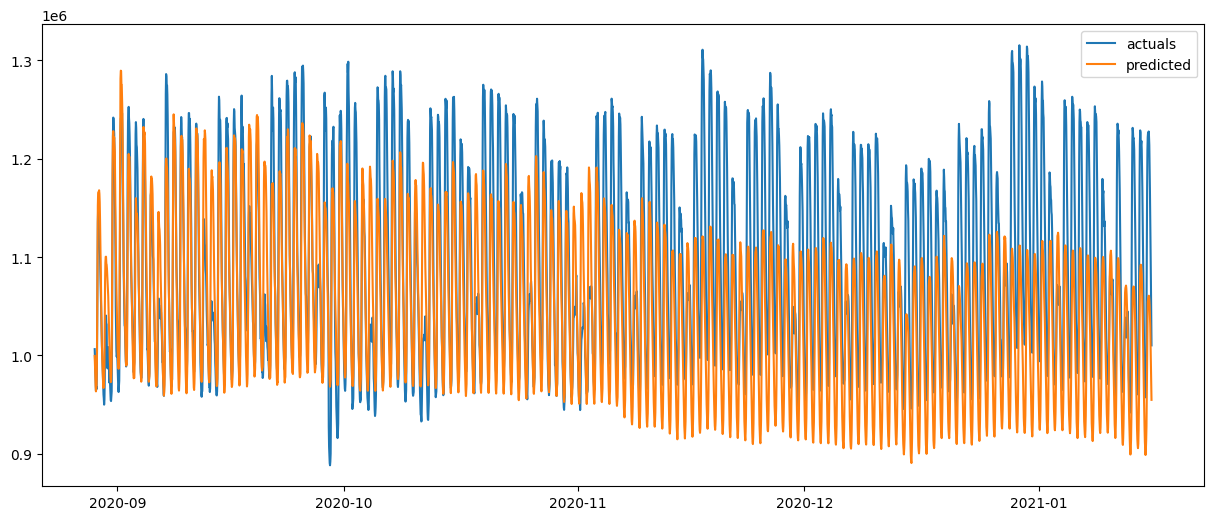

In [145]:
plt.figure(figsize=(15,6))
plt.plot(testing_set['load'])
plt.plot(testing_set['predicted'])
plt.legend(['actuals','predicted'])
plt.show()

In [146]:
steps = 48
new_mae = calculate_mae(testing_set['load'][:steps], testing_set['predicted'][:steps])
new_mape = calculate_mape(testing_set['load'][:steps], testing_set['predicted'][:steps])
new_rmse = calculate_rmse(testing_set['load'][:steps], testing_set['predicted'][:steps])

In [147]:
print('MAE: '+ str(new_mae))
print('MAPE: '+ str(new_mape))
print('RMSE: '+ str(new_rmse))

MAE: 29963.17255
MAPE: 2.9321432237776874
RMSE: 40307.05681361964


it performs worse and idk why bro 

In [256]:
def calculate_mae_n(actual, predicted):
    return np.mean(np.abs(actual - predicted))

def calculate_mape_n(actual, predicted):
    return np.mean(np.abs((actual - predicted)/actual))*100

def calculate_rmse_n(actual, predicted):
    return math.sqrt(np.square(np.subtract(actual,predicted)).mean())

In [254]:
testing_set['MAE'] = 0
testing_set['MAPE'] = 0
testing_set['RMSE'] = 0

In [257]:
for i in range(48):
    testing_set['MAE'][i] = calculate_mae_n(testing_set['load'][i], testing_set['predicted'][i])
    testing_set['MAPE'][i] = calculate_mape_n(testing_set['load'][i], testing_set['predicted'][i])
    testing_set['RMSE'][i] = calculate_rmse_n(testing_set['load'][i], testing_set['predicted'][i])

C:\Users\danie\AppData\Local\Temp\ipykernel_6648\2930267382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_set['MAE'][i] = calculate_mae_n(testing_set['load'][i], testing_set['predicted'][i])
C:\Users\danie\AppData\Local\Temp\ipykernel_6648\2930267382.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_set['MAPE'][i] = calculate_mape_n(testing_set['load'][i], testing_set['predicted'][i])
C:\Users\danie\AppData\Local\Temp\ipykernel_6648\2930267382.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

In [258]:
testing_set.head()

,load,predicted,MAE,MAPE,RMSE
time,,,,,
2020-08-29 00:00:00,1006401.41800,999426.68750,6974.73050,0.69304,6974.73050
2020-08-29 01:00:00,994947.13210,989025.12500,5922.00710,0.59521,5922.00710
2020-08-29 02:00:00,980939.98810,980271.25000,668.73810,0.06817,668.73810
2020-08-29 03:00:00,971320.69410,970838.93750,481.75660,0.04960,481.75660
2020-08-29 04:00:00,964265.83410,968343.68750,4077.85340,0.42290,4077.85340


#### 48-hour prediction

### Backtesting